## Facies classification using Random Forest Classifier (submission 5)
<a rel="license" href="https://creativecommons.org/licenses/by-sa/4.0/">
  <img alt="Creative Commons License BY-SA" align="left" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png">
</a>
<br>
##### Dan Hallau

In [1]:
import pandas as pd
import numpy as np
from math import radians, cos, sin, asin, sqrt
import itertools

from sklearn import neighbors
from sklearn import preprocessing
from sklearn import ensemble
from sklearn.model_selection import LeaveOneGroupOut, LeavePGroupsOut

import inversion

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#### Load training data

In [2]:
df = pd.read_csv('../facies_vectors.csv')

#### Build features

In the real world it would be unusual to have neutron-density cross-plot porosity (i.e. PHIND) without the corresponding raw input curves, namely bulk density and neutron porosity, as we have in this contest dataset. So as part of the feature engineering process, I back-calculate estimates of those raw curves from the provided DeltaPHI and PHIND curves. One issue with this approach though is that cross-plot porosity differs between vendors, toolstrings, and software packages, and it is not known exactly how the PHIND in this dataset was computed. So I make the assumption here that PHIND ≈ sum of squares porosity, which is usually an adequate approximation of neutron-density crossplot porosity. That equation looks like this: 

$$PHIND = \sqrt{\frac{NPHI^2 + DPHI^2}{2}}$$

and it is assumed here that DeltaPHI is:

$$DeltaPHI = NPHI - DPHI$$

The functions below use the relationships from the above equations (...two equations, two unknowns...) to estimate NPHI and DPHI (and consequently RHOB).

Once we have RHOB, we can use it combined with PE to estimate apparent grain density (RHOMAA) and apparent photoelectric capture cross-section (UMAA), which are useful in lithology estimations from well logs.

In [3]:
def estimate_dphi(df):
    return ((4*(df['PHIND']**2) - (df['DeltaPHI']**2))**0.5 - df['DeltaPHI']) / 2

def estimate_rhob(df):
    return (2.71 - (df['DPHI_EST']/100) * 1.71)

def estimate_nphi(df):
    return df['DPHI_EST'] + df['DeltaPHI']

def compute_rhomaa(df):
    return (df['RHOB_EST'] - (df['PHIND'] / 100)) / (1 - df['PHIND'] / 100)
            
def compute_umaa(df):
    return ((df['PE'] * df['RHOB_EST']) - (df['PHIND']/100 * 0.398)) / (1 - df['PHIND'] / 100)

Because solving the sum of squares equation involved the quadratic formula, in some cases imaginary numbers result due to porosities being negative, which is what the warning below is about.

In [4]:
df['DPHI_EST'] = df.apply(lambda x: estimate_dphi(x), axis=1).astype(float)
df['RHOB_EST'] = df.apply(lambda x: estimate_rhob(x), axis=1)
df['NPHI_EST'] = df.apply(lambda x: estimate_nphi(x), axis=1)
df['RHOMAA_EST'] = df.apply(lambda x: compute_rhomaa(x), axis=1)

/home/delta/anaconda3/lib/python3.5/site-packages/pandas/core/common.py:1920: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype)


#### Regress missing PE values

In [5]:
pe = df.dropna()

PE = pe['PE'].values
wells = pe['Well Name'].values

drop_list_pe = ['Formation', 'Well Name', 'Facies', 'Depth', 'PE', 'RELPOS'] 

fv_pe = pe.drop(drop_list_pe, axis=1).values

X_pe = preprocessing.StandardScaler().fit(fv_pe).transform(fv_pe)
y_pe = PE

reg = neighbors.KNeighborsRegressor(n_neighbors=40, weights='distance')

logo = LeaveOneGroupOut()
f1knn_pe = []

for train, test in logo.split(X_pe, y_pe, groups=wells):
    well_name = wells[test[0]]
    reg.fit(X_pe[train], y_pe[train])
    score = reg.fit(X_pe[train], y_pe[train]).score(X_pe[test], y_pe[test])
    print("{:>20s}  {:.3f}".format(well_name, score))
    f1knn_pe.append(score)
    
print("-Average leave-one-well-out F1 Score: %6f" % (np.mean(f1knn_pe)))

     CHURCHMAN BIBLE  0.710
      CROSS H CATTLE  0.665
            LUKE G U  0.547
               NEWBY  0.401
               NOLAN  0.534
          Recruit F9  0.794
             SHANKLE  0.380
           SHRIMPLIN  0.241
-Average leave-one-well-out F1 Score: 0.534165


#### Apply regression model to missing PE values and merge back into dataframe:

In [6]:
reg.fit(X_pe, y_pe)
fv_apply = df.drop(drop_list_pe, axis=1).values
X_apply = preprocessing.StandardScaler().fit(fv_apply).transform(fv_apply)
df['PE_EST'] = reg.predict(X_apply)
df.PE = df.PE.combine_first(df.PE_EST)

#### Compute UMAA for lithology model

In [7]:
df['UMAA_EST'] = df.apply(lambda x: compute_umaa(x), axis=1)

#### Umaa Rhomaa plot

Just for fun, below is a basic Umaa-Rhomaa plot to view relative abundances of quartz, calcite, dolomite, and clay. The red triangle represents a ternary solution for QTZ, CAL, and DOL, while the green triangle represents a solution for QTZ, CAL, and CLAY (illite). 

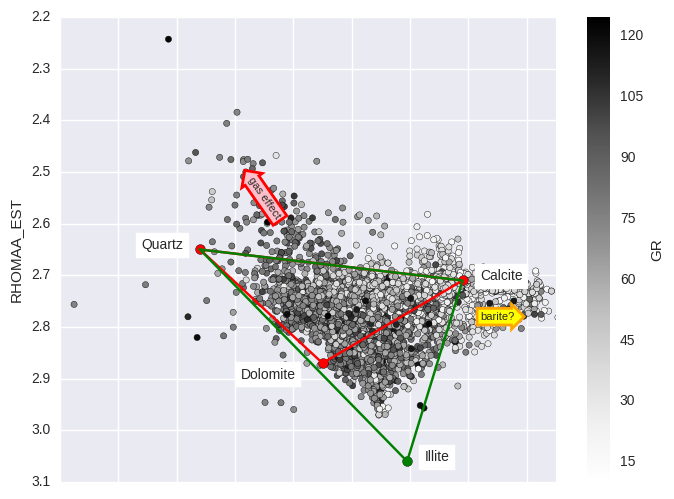

In [8]:
df[df.GR < 125].plot(kind='scatter', x='UMAA_EST', y='RHOMAA_EST', c='GR', figsize=(8,6))
plt.ylim(3.1, 2.2)
plt.xlim(0.0, 17.0)
plt.plot([4.8, 9.0, 13.8, 4.8], [2.65, 2.87, 2.71, 2.65], c='r')
plt.plot([4.8, 11.9, 13.8, 4.8], [2.65, 3.06, 2.71, 2.65], c='g')
plt.scatter([4.8], [2.65], s=50, c='r')
plt.scatter([9.0], [2.87], s=50, c='r')
plt.scatter([13.8], [2.71], s=50, c='r')
plt.scatter([11.9], [3.06], s=50, c='g')
plt.text(2.8, 2.65, 'Quartz', backgroundcolor='w')
plt.text(14.4, 2.71, 'Calcite', backgroundcolor='w')
plt.text(6.2, 2.90, 'Dolomite', backgroundcolor='w')
plt.text(12.5, 3.06, 'Illite', backgroundcolor='w')
plt.text(7.0, 2.55, "gas effect", ha="center", va="center", rotation=-55,
            size=8, bbox=dict(boxstyle="larrow,pad=0.3", fc="pink", ec="red", lw=2))
plt.text(15.0, 2.78, "barite?", ha="center", va="center", rotation=0,
            size=8, bbox=dict(boxstyle="rarrow,pad=0.3", fc="yellow", ec="orange", lw=2))

Here I use matrix inversion to "solve" the ternary plot for each lithologic component. Essentially each datapoint is a mix of the three components defined by the ternary diagram, with abundances of each defined by the relative distances from each endpoint. I use a GR cutoff of 40 API to determine when to use either the QTZ-CAL-DOL or QTZ-CAL-CLAY ternary solutions. In other words, it is assumed that below 40 API, there is 0% clay, and above 40 API there is 0% dolomite, and also that these four lithologic components are the only components in these rocks. Admittedly it's not a great assumption, especially since the ternary plot indicates other stuff is going on. For example the high Umaa datapoints near the Calcite endpoint may indicate some heavy minerals (e.g., pyrite) or even barite-weighted mud. The "pull" of datapoints to the northwest quadrant probably reflects some gas effect, so my lithologies in those gassy zones will be skewed.

In [9]:
# QTZ-CAL-CLAY
ur1 = inversion.UmaaRhomaa()
ur1.set_dol_uma(11.9)
ur1.set_dol_rhoma(3.06)
# QTZ-CAL-DOL
ur2 = inversion.UmaaRhomaa()

df['UR_QTZ'] = np.nan
df['UR_CLY'] = np.nan
df['UR_CAL'] = np.nan
df['UR_DOL'] = np.nan

df.ix[df.GR >= 40, 'UR_QTZ'] = df.ix[df.GR >= 40].apply(lambda x: ur1.get_qtz(x.UMAA_EST, x.RHOMAA_EST), axis=1)
df.ix[df.GR >= 40, 'UR_CLY'] = df.ix[df.GR >= 40].apply(lambda x: ur1.get_dol(x.UMAA_EST, x.RHOMAA_EST), axis=1) 
df.ix[df.GR >= 40, 'UR_CAL'] = df.ix[df.GR >= 40].apply(lambda x: ur1.get_cal(x.UMAA_EST, x.RHOMAA_EST), axis=1)
df.ix[df.GR >= 40, 'UR_DOL'] = 0

df.ix[df.GR < 40, 'UR_QTZ'] = df.ix[df.GR < 40].apply(lambda x: ur2.get_qtz(x.UMAA_EST, x.RHOMAA_EST), axis=1)
df.ix[df.GR < 40, 'UR_DOL'] = df.ix[df.GR < 40].apply(lambda x: ur2.get_dol(x.UMAA_EST, x.RHOMAA_EST), axis=1) 
df.ix[df.GR < 40, 'UR_CAL'] = df.ix[df.GR < 40].apply(lambda x: ur2.get_cal(x.UMAA_EST, x.RHOMAA_EST), axis=1)
df.ix[df.GR < 40, 'UR_CLY'] = 0

#### Plot facies by formation to see if the Formation feature will be useful

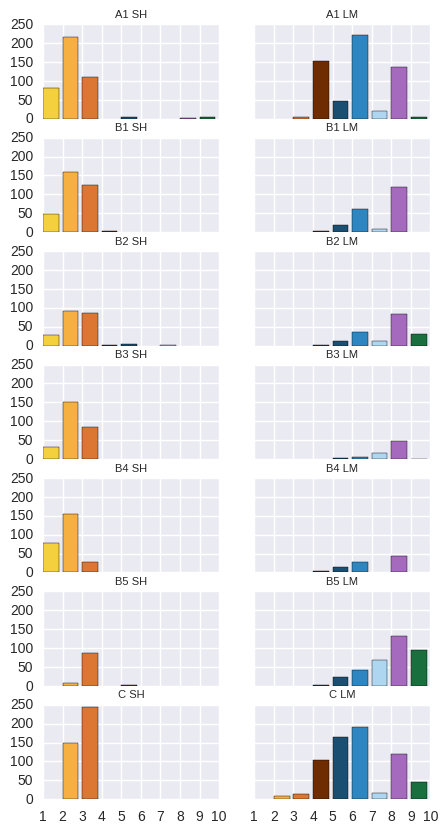

In [10]:
facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00', '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']
fms = df.Formation.unique()
fig, ax = plt.subplots(int(len(fms) / 2), 2, sharey=True, sharex=True, figsize=(5,10))
for i, fm in enumerate(fms):
    facies_counts = df[df.Formation == fm]['Facies'].value_counts().sort_index()
    colors = [facies_colors[i-1] for i in facies_counts.index]
    ax[int(i/2), i%2].bar(facies_counts.index, height=facies_counts, color=colors)
    ax[int(i/2), i%2].set_title(fm, size=8)

#### Group formations by similar facies distributions

In [11]:
fm_groups = [['A1 SH', 'B1 SH', 'B2 SH', 'B3 SH', 'B4 SH'],
             ['B5 SH', 'C SH'],
             ['A1 LM', 'C LM'],
             ['B1 LM', 'B3 LM', 'B4 LM'],
             ['B2 LM', 'B5 LM']]

fm_group_dict = {fm:i for i, l in enumerate(fm_groups) for fm in l}
df['FM_GRP'] = df.Formation.map(fm_group_dict)

#### Make dummy variables from the categorical Formation feature

In [12]:
#df = pd.get_dummies(df, prefix='FM_GRP', columns=['FM_GRP'])
df = pd.get_dummies(df, prefix='FM', columns=['Formation'])

#### Compute Archie water saturation

In [13]:
def archie(df):
    return np.sqrt(0.08 / ((df.PHIND ** 2) * (10 ** df.ILD_log10)))

In [14]:
df['SW'] = df.apply(lambda x: archie(x), axis=1)

#### Get distances between wells

In [15]:
# modified from jesper
latlong = pd.DataFrame({"SHRIMPLIN": [37.978076, -100.987305], #
                        "ALEXANDER D": [37.6747257, -101.1675259], #
                        "SHANKLE": [38.0633799, -101.3920543], #
                        "LUKE G U": [37.4499614, -101.6121913], #
                        "KIMZEY A": [37.12289, -101.39697], #
                        "CROSS H CATTLE": [37.9105826, -101.6464517], #
                        "NOLAN": [37.7866294, -101.0451641], #?
                        "NEWBY": [37.3172442, -101.3546995], #
                        "CHURCHMAN BIBLE": [37.3497658, -101.1060761], #?
                        "STUART": [37.4857262, -101.1391063], #
                        "CRAWFORD": [37.1893654, -101.1494994], #?
                        "Recruit F9": [0,0]})

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    km = 6367 * c
    return km

def get_lat(df):
    return latlong[df['Well Name']][0]

def get_long(df):
    return latlong[df['Well Name']][1]

#### Add latitude and longitude as features, add distances to every other well as features

In [16]:
df['LAT'] = df.apply(lambda x: get_lat(x), axis=1)
df['LON'] = df.apply(lambda x: get_long(x), axis=1)

dist_dict = {}
for k in latlong:
    dict_name = k + '_DISTANCES'
    k_dict = {}
    lat1 = latlong[k][0]
    lon1 = latlong[k][1]
    for l in latlong:
        lat2 = latlong[l][0]
        lon2 = latlong[l][1]
        if l == 'Recruit F9':       
            dist = haversine(0, 0, 0, 0)            
        elif k == "Recruit F9":
            dist = haversine(0, 0, 0, 0)
        else:
            dist = haversine(lon1, lat1, lon2, lat2)
        k_dict[l] = dist
    dist_dict[dict_name] = k_dict
    
for i in dist_dict:
    df[i] = np.nan
    for j in dist_dict[i]:
        df.loc[df['Well Name'] == j, i] = dist_dict[i][j]  

#### Fit RandomForect model and apply LeavePGroupsOut test

There is some bad log data in this dataset which I'd guess is due to rugose hole. PHIND gets as high at 80%, which is certainly spurious, so I'll remove data with cross-plot porosity greater than 40% from the dataset. CROSS H CATTLE well also looks pretty different from the others so I'm going to remove it from the training set.

In [17]:
df1 = df.dropna()
df1 = df1[(df1['Well Name'] != 'CROSS H CATTLE') & (df.PHIND < 40.0)]

facies = df1['Facies'].values
wells = df1['Well Name'].values

drop_list = ['Well Name', 'Facies', 'Depth', 'DPHI_EST', 'NPHI_EST', 'DeltaPHI',
             'UMAA_EST', 'UR_QTZ', 'PE_EST', 'Recruit F9_DISTANCES']

fv = df1.drop(drop_list, axis=1).values
X = preprocessing.StandardScaler().fit(fv).transform(fv)
y = facies

ne_grid = [150]
mf_grid = ['auto']
md_grid = [10]
msl_grid = [5]
mss_grid = [10]
keys = ['n_estimators', 'max_features', 'max_depth', 'min_samples_leaf', 'min_samples_split']
param_sets = itertools.product(ne_grid, mf_grid, md_grid, msl_grid, mss_grid)
param_grid = [dict(zip(keys, i)) for i in param_sets]

clf_list = []
for i, d in enumerate(param_grid):
    clf = ensemble.RandomForestClassifier(n_estimators=d['n_estimators'],
                                          class_weight='balanced',
                                          min_samples_leaf=d['min_samples_leaf'],
                                          min_samples_split=d['min_samples_split'],
                                          max_features=d['max_features'],
                                          max_depth=d['max_depth'],
                                          n_jobs=-1)

    lpgo = LeavePGroupsOut(n_groups=2)
    f1rfc = []
    for train, test in lpgo.split(X, y, groups=wells):
        clf.fit(X[train], y[train])
        score = clf.fit(X[train], y[train]).score(X[test], y[test])
        f1rfc.append(score)        
    print("Average leave-two-wells-out F1 Score: %6f" % (np.mean(f1rfc)))
    clf_list.append((clf, np.mean(f1rfc)))

np.max([i[1] for i in clf_list])

Average leave-two-wells-out F1 Score: 0.576423


0.5764229404870842

In [18]:
fi = list(zip(df1.drop(drop_list, axis=1).columns, clf.feature_importances_))
fi

[('GR', 0.061266253444025566),
 ('ILD_log10', 0.057676351444460441),
 ('PHIND', 0.056507353586095731),
 ('PE', 0.05068086772387758),
 ('NM_M', 0.070532967422952023),
 ('RELPOS', 0.049844034179571499),
 ('RHOB_EST', 0.047302019046631595),
 ('RHOMAA_EST', 0.040709091257007314),
 ('UR_CLY', 0.04377775385315235),
 ('UR_CAL', 0.048629415107263742),
 ('UR_DOL', 0.017258571018552507),
 ('FM_GRP', 0.093541846608688514),
 ('FM_A1 LM', 0.013319148750375128),
 ('FM_A1 SH', 0.036626476597869495),
 ('FM_B1 LM', 0.0014308854356287022),
 ('FM_B1 SH', 0.0011344989383414207),
 ('FM_B2 LM', 0.0016466558060328317),
 ('FM_B2 SH', 0.0058361653858015972),
 ('FM_B3 LM', 0.0017623297277343853),
 ('FM_B3 SH', 0.00088166639914237196),
 ('FM_B4 LM', 0.00042266959662909007),
 ('FM_B4 SH', 0.0013469655036231884),
 ('FM_B5 LM', 0.015502065764566015),
 ('FM_B5 SH', 0.00084565150404594983),
 ('FM_C LM', 0.0090812513431416299),
 ('FM_C SH', 0.00153999837785131),
 ('SW', 0.039090125398328138),
 ('LAT', 0.02127797188218

#### Apply model to validation dataset

In [19]:
# refit model to entire training set
clf.fit(X, y)

# load validation data
vd = pd.read_csv('../validation_data_nofacies.csv')

# compute extra log data features
vd['DPHI_EST'] = vd.apply(lambda x: estimate_dphi(x), axis=1).astype(float)
vd['RHOB_EST'] = vd.apply(lambda x: estimate_rhob(x), axis=1)
vd['NPHI_EST'] = vd.apply(lambda x: estimate_nphi(x), axis=1)
vd['RHOMAA_EST'] = vd.apply(lambda x: compute_rhomaa(x), axis=1)
vd['UMAA_EST'] = vd.apply(lambda x: compute_umaa(x), axis=1)

# Estimate lithology using Umaa Rhomaa solution
vd['UR_QTZ'] = np.nan
vd['UR_CLY'] = np.nan
vd['UR_CAL'] = np.nan
vd['UR_DOL'] = np.nan
vd.ix[vd.GR >= 40, 'UR_QTZ'] = vd.ix[vd.GR >= 40].apply(lambda x: ur1.get_qtz(x.UMAA_EST, x.RHOMAA_EST), axis=1)
vd.ix[vd.GR >= 40, 'UR_CLY'] = vd.ix[vd.GR >= 40].apply(lambda x: ur1.get_dol(x.UMAA_EST, x.RHOMAA_EST), axis=1) 
vd.ix[vd.GR >= 40, 'UR_CAL'] = vd.ix[vd.GR >= 40].apply(lambda x: ur1.get_cal(x.UMAA_EST, x.RHOMAA_EST), axis=1)
vd.ix[vd.GR >= 40, 'UR_DOL'] = 0
vd.ix[vd.GR < 40, 'UR_QTZ'] = vd.ix[vd.GR < 40].apply(lambda x: ur2.get_qtz(x.UMAA_EST, x.RHOMAA_EST), axis=1)
vd.ix[vd.GR < 40, 'UR_DOL'] = vd.ix[vd.GR < 40].apply(lambda x: ur2.get_dol(x.UMAA_EST, x.RHOMAA_EST), axis=1) 
vd.ix[vd.GR < 40, 'UR_CAL'] = vd.ix[vd.GR < 40].apply(lambda x: ur2.get_cal(x.UMAA_EST, x.RHOMAA_EST), axis=1)
vd.ix[vd.GR < 40, 'UR_CLY'] = 0

# Formation grouping
vd['FM_GRP'] = vd.Formation.map(fm_group_dict)
vd = pd.get_dummies(vd, prefix='FM', columns=['Formation'])

# Water saturation
vd['SW'] = vd.apply(lambda x: archie(x), axis=1)

# Lat-long features
vd['LAT'] = vd.apply(lambda x: get_lat(x), axis=1)
vd['LON'] = vd.apply(lambda x: get_long(x), axis=1)
for i in dist_dict:
    vd[i] = np.nan
    for j in dist_dict[i]:
        vd.loc[vd['Well Name'] == j, i] = dist_dict[i][j]

# Apply final model
drop_list1 = ['Well Name', 'Depth', 'DPHI_EST', 'NPHI_EST', 'DeltaPHI',
             'UMAA_EST', 'UR_QTZ', 'Recruit F9_DISTANCES']
fv_vd1 = vd.drop(drop_list1, axis=1).values
X_vd1 = preprocessing.StandardScaler().fit(fv_vd1).transform(fv_vd1)
vd_predicted_facies = clf.predict(X_vd1)

In [20]:
vd['Facies'] = vd_predicted_facies
vd.to_csv('RFC_submission_5_predictions.csv')

In [21]:
vd_predicted_facies

array([2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 7, 8,
       8, 6, 6, 6, 6, 6, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 6, 4, 4, 4, 4,
       6, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 6,
       6, 6, 6, 6, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 4, 2, 2, 2, 3, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 7, 4, 4, 4, 4, 6, 5, 6, 6, 6, 6, 6, 6, 8, 8, 8, 8, 8, 8, 2, 2,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 6, 5, 5, 5, 2, 2, 3,
       3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 8, 8, 8, 8,
       8, 8, 8, 8, 7, 8, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3,
       3, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 3, 3, 3, 3, 8, 8, 8, 8,
       8, 8,